In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_7_adaptation_'

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import dill


from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# print(mpl.rcParams.keys())


In [5]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/20.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/4.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0
############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

In [6]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax



#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    gaba_inh += 0.16
    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p



# Input

In [7]:

# GABA parameter
sbc_input_intensities = np.linspace(1.0,0.0,41)
gbc_input_intensities = np.linspace(0.0,1.0,41)

adaptor_tone =np.linspace(0.5,-0.5,41)


# store values for different parameters
q_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))


############################################################
#                      Simulation                          #
############################################################

for l in range(len(adaptor_tone)):
    for k in range(len(sbc_input_intensities)):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 1.0

        ### MNTB inhibitory input (contra-lateral) ###
        gbc_center_frequencyBand =2
        gbc_input_strength = gbc_input_intensities[k]
            
        # build ramps
        onset = 400
        s_gbc_all[onset:onset+1200,gbc_center_frequencyBand] = 0.5+adaptor_tone[l] 
        s_gbc_all[2100:,gbc_center_frequencyBand] = 1 * gbc_input_strength


        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


        # LSO direct excitatory input (ipsi-lateral)
        sbc_center_frequencyBand = 2
        sbc_input_strength = sbc_input_intensities[k]

        # build ramps
        s_sbc_all[onset:onset+1200,sbc_center_frequencyBand] = 0.5-adaptor_tone[l]
        s_sbc_all[2100:,sbc_center_frequencyBand] = 1 * sbc_input_strength


        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


        # Convolve with gauss curve to build a temporal ramp
        gauss_mask = gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1)
        s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')
        gauss_mask = gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1)
        s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')

        # normalize input
#         maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
#         s_gbc_all /= maxi
#         s_sbc_all /= maxi




        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.6)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0) # <- not used

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

                gaba_inh_values[i,w] =   p_all[l,k,i,w]*1
                gaba_exc_values[i,w] =   p_all[l,k,i,w]*2.0




                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])       

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

                p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))





In [5]:
# dill.dump_session('fig_7_dynamic_adaptation')
dill.load_session('fig_7_dynamic_adaptation')

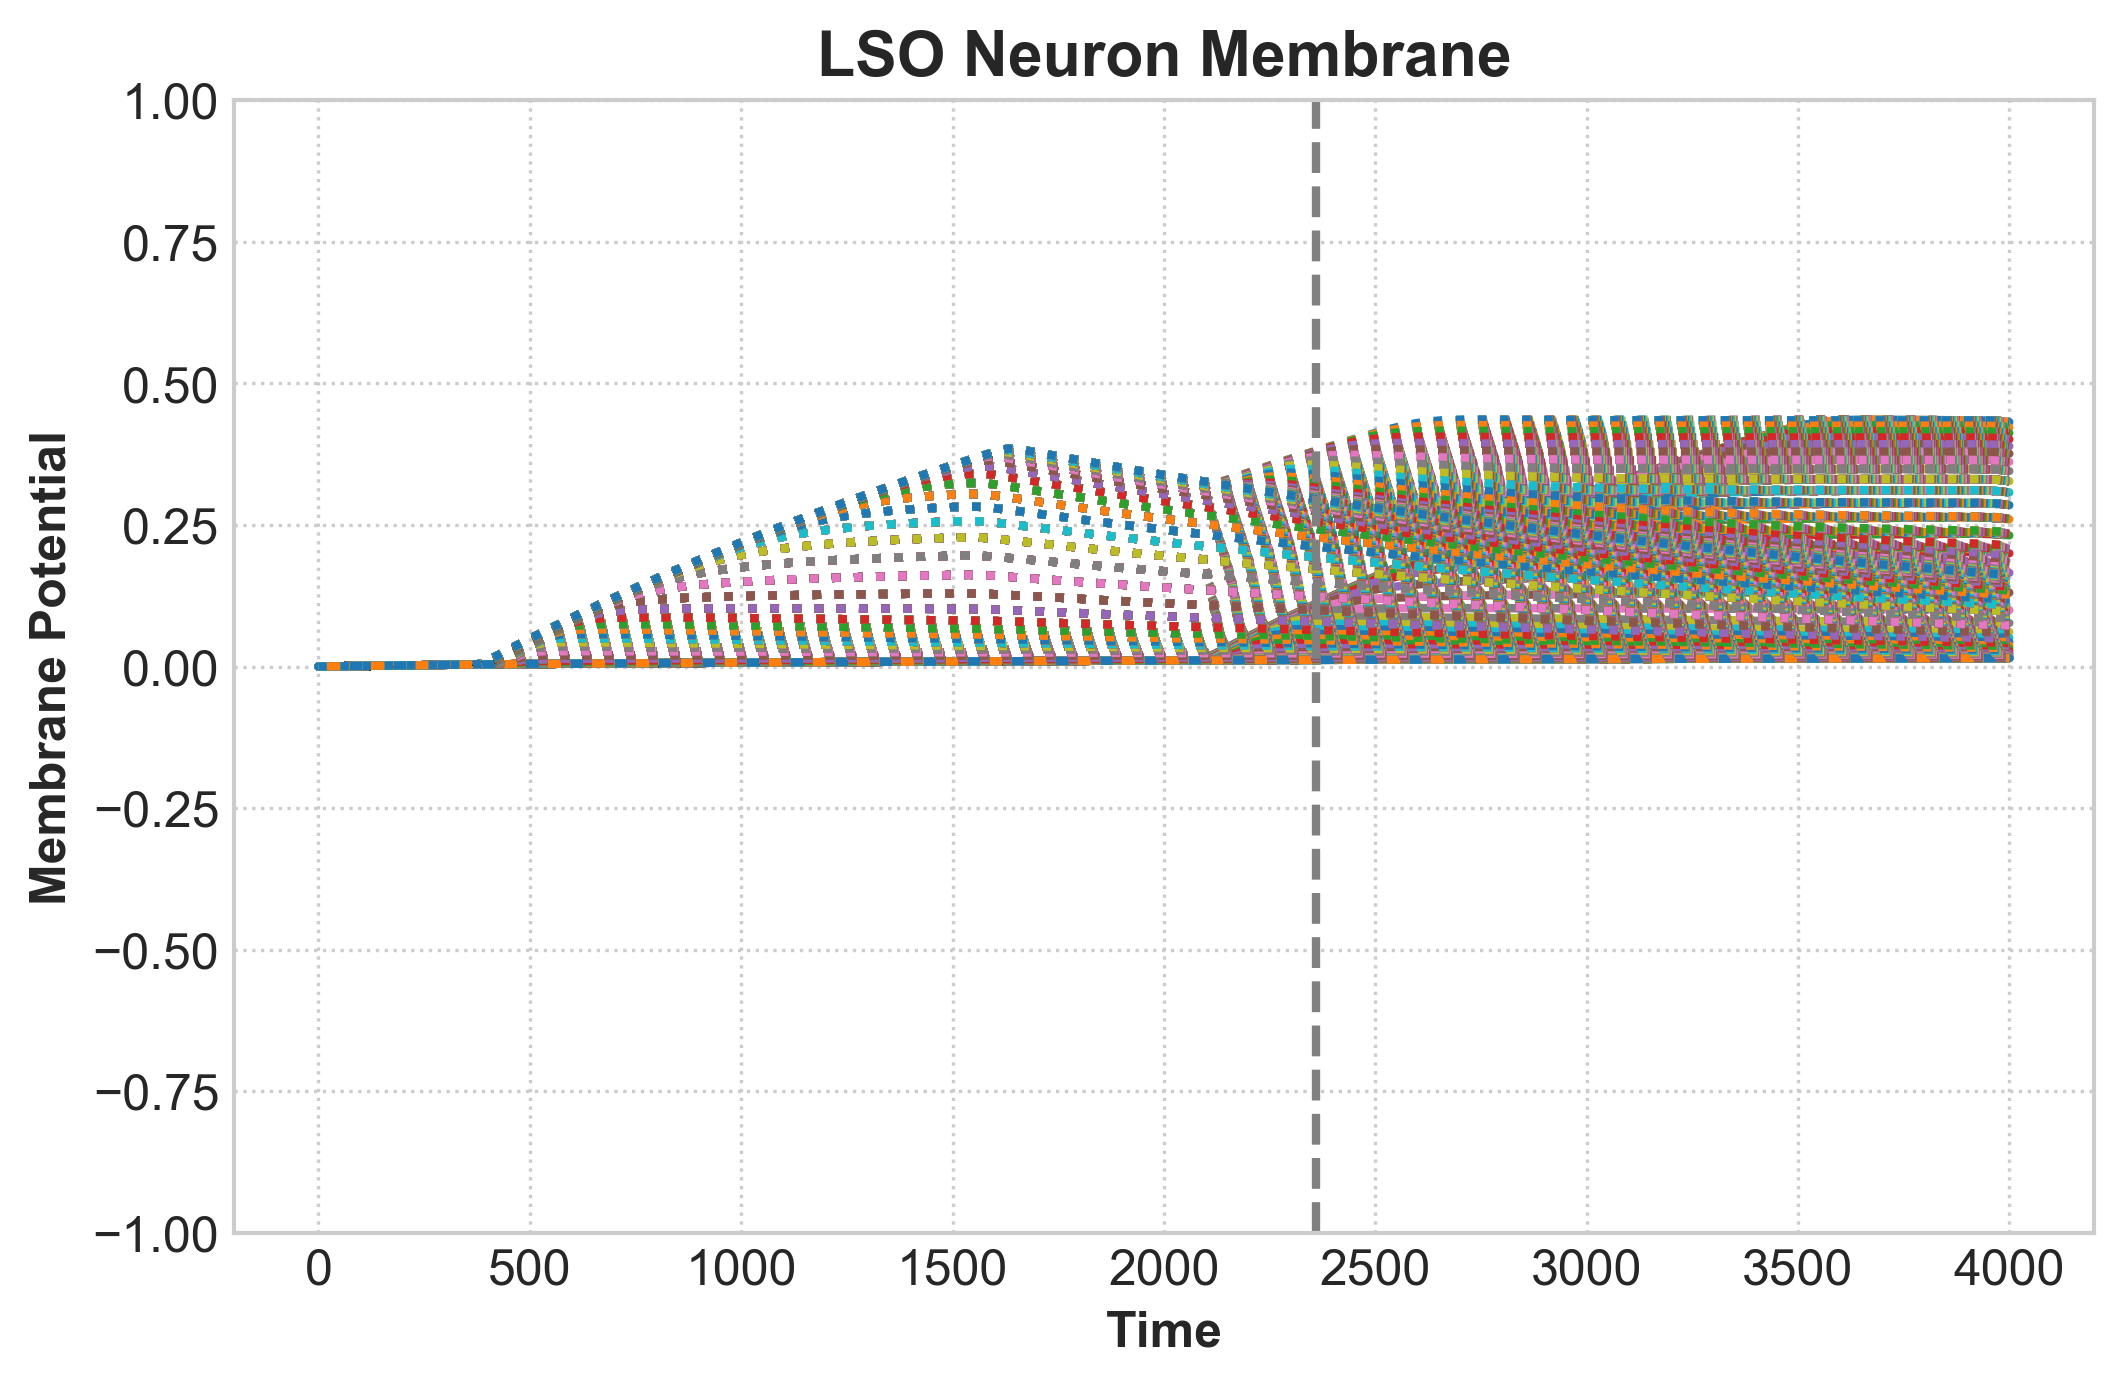

In [22]:
# Define the times when to probe
probing_times = [2360]
# show LSO neuron membrane
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]
fig = plt.figure()
ax2 = fig.add_subplot(111)
for j in range(0,len(adaptor_tone)):
    if j == 0:
        line_style = '-'
    elif j == 1:
        line_style = '--'
    else:
        line_style = ':'

    for i in range(0,r.shape[1]):
        plt.plot(p[j,i,:],linestyle=line_style)
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1])
plt.show()

0.0
0.0
0.0


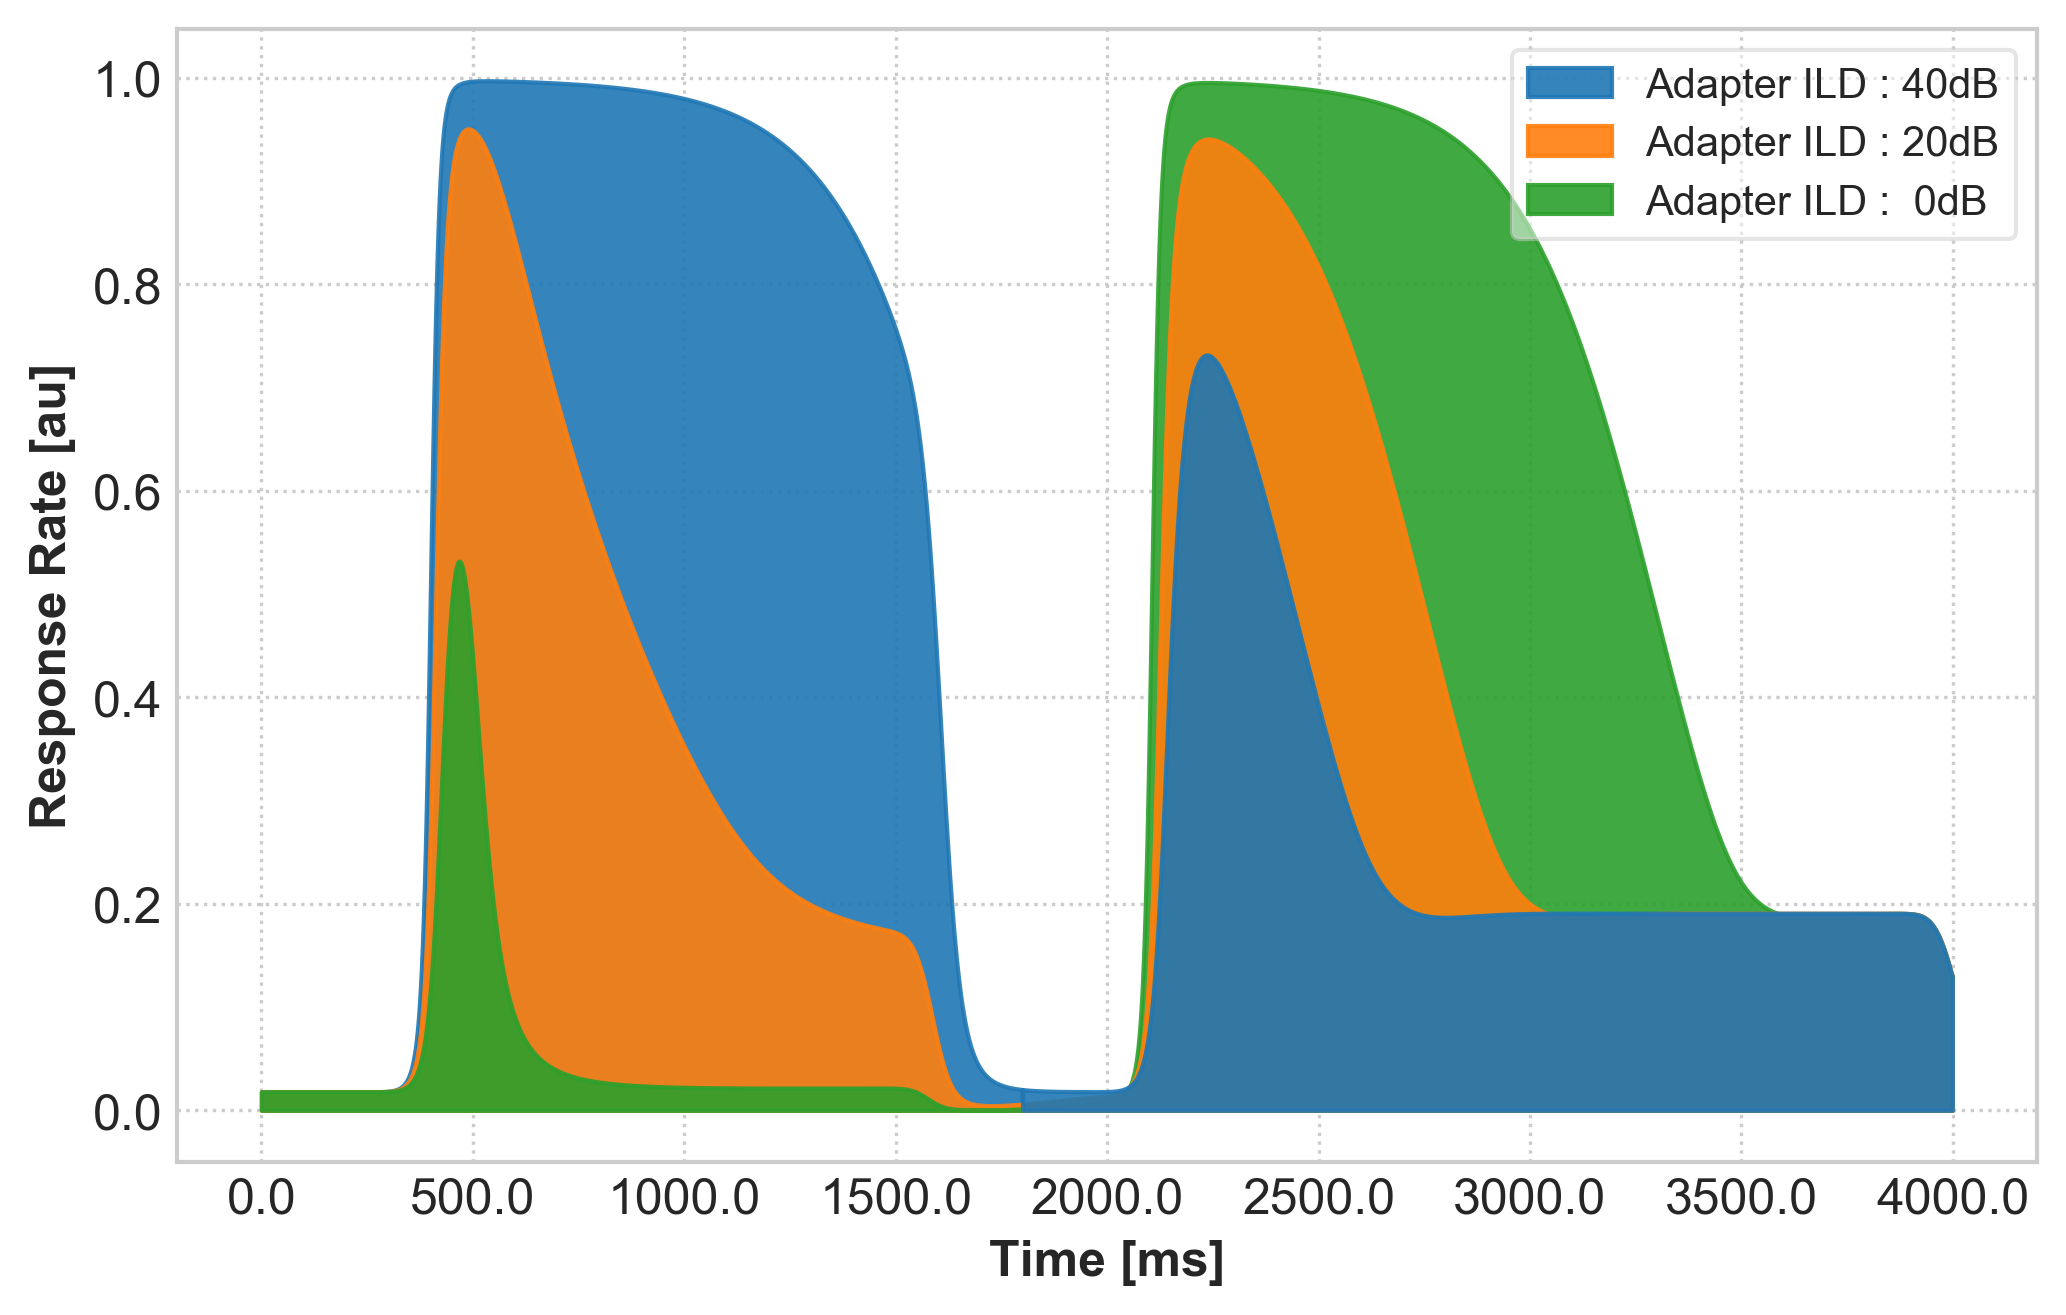

In [19]:

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()


plotting_range = np.arange(0,1800)
## show LSO neuron response
ax2 = fig.add_subplot(111)
l = 0
# adaptor_levels = [7,int(r.shape[0]/2)+4,r.shape[0]-4]
# adaptor_levels = [10,int(r.shape[0]/2)+5,r.shape[0]-1]
# adaptor_levels = [r.shape[0]-1,int(r.shape[0]/2)+5,10]
adaptor_levels = [r.shape[0]-1,int(r.shape[0]/2)+10,int(r.shape[0]/2)+0]
# adaptor_levels = range(0,r.shape[0])
for j in adaptor_levels:
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'

    l +=1
    for i in range(0,1):
        tmp = g_r_out(r[j,i,:])
        print(gbc_input_intensities[i])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color,label='Level Difference = {0:.1f}'.format(sbc_input_intensities[i]-gbc_input_intensities[i]))
        
        if adaptor_tone[j] == 0:
            ax2.fill_between(t[plotting_range]*1000,tmp[plotting_range], 0, color = face_color, alpha=0.9,label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[j]*200))
        else:
            ax2.fill_between(t[plotting_range]*1000,tmp[plotting_range], 0, color = face_color, alpha=0.9,label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[j]*-80))
#         if adaptor_tone[j] == 0:
#             ax2.plot(t[plotting_range]*1000,tmp[plotting_range], color = face_color, alpha=0.9,label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[j]*200))
#         else:
#             ax2.plot(t[plotting_range]*1000,tmp[plotting_range], color = face_color, alpha=0.9,label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[j]*-200))


plotting_range = np.arange(1800,4000)
## show LSO neuron response
for j in adaptor_levels[::-1]:
    l -=1
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'



    for i in range(0,1):
        tmp = g_r_out(r[j,i,:])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color)
        ax2.fill_between(t[plotting_range]*1000,tmp[plotting_range], 0, color = face_color,  alpha=0.9)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range], color = face_color,  alpha=0.9)
        
        
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
# plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.ylabel('Response Rate [au]')
plt.xlabel('Time [ms]')
ax2.set_xticklabels(ax2.get_xticks())
ax2.invert_xaxis()
lgd = plt.legend()

plt.savefig(figure_name + 'membrane_adapter.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'membrane_adapter.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'membrane_adapter.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




The ratio between the inhibitory feedback on the excitatory and the inhibitory feedback on the inhibitory input is a crucial here since it determines the sensitivity of the neuron for tones succeeding an adaptor tone. If the we have a high ratio, say the GABA_exc is two times higher than the GABA_inh, then the difference of level for the succeeding tone is smaller then for for higher ratios e.g. a ratio of GABA_exc = GABA_inh * 3.5 creates a larger difference in succeeding sounds. This behavior leads to a bigger shift of ILD values towards the more/most sensitive range. Psychophysics expiriments would need to be conducte to see the adaptation value and thereby the ratio between the inhibitory feedback on the excitatory and the inhibitory feedback on the inhibitory input.

Maybe we plot value for different ratios...

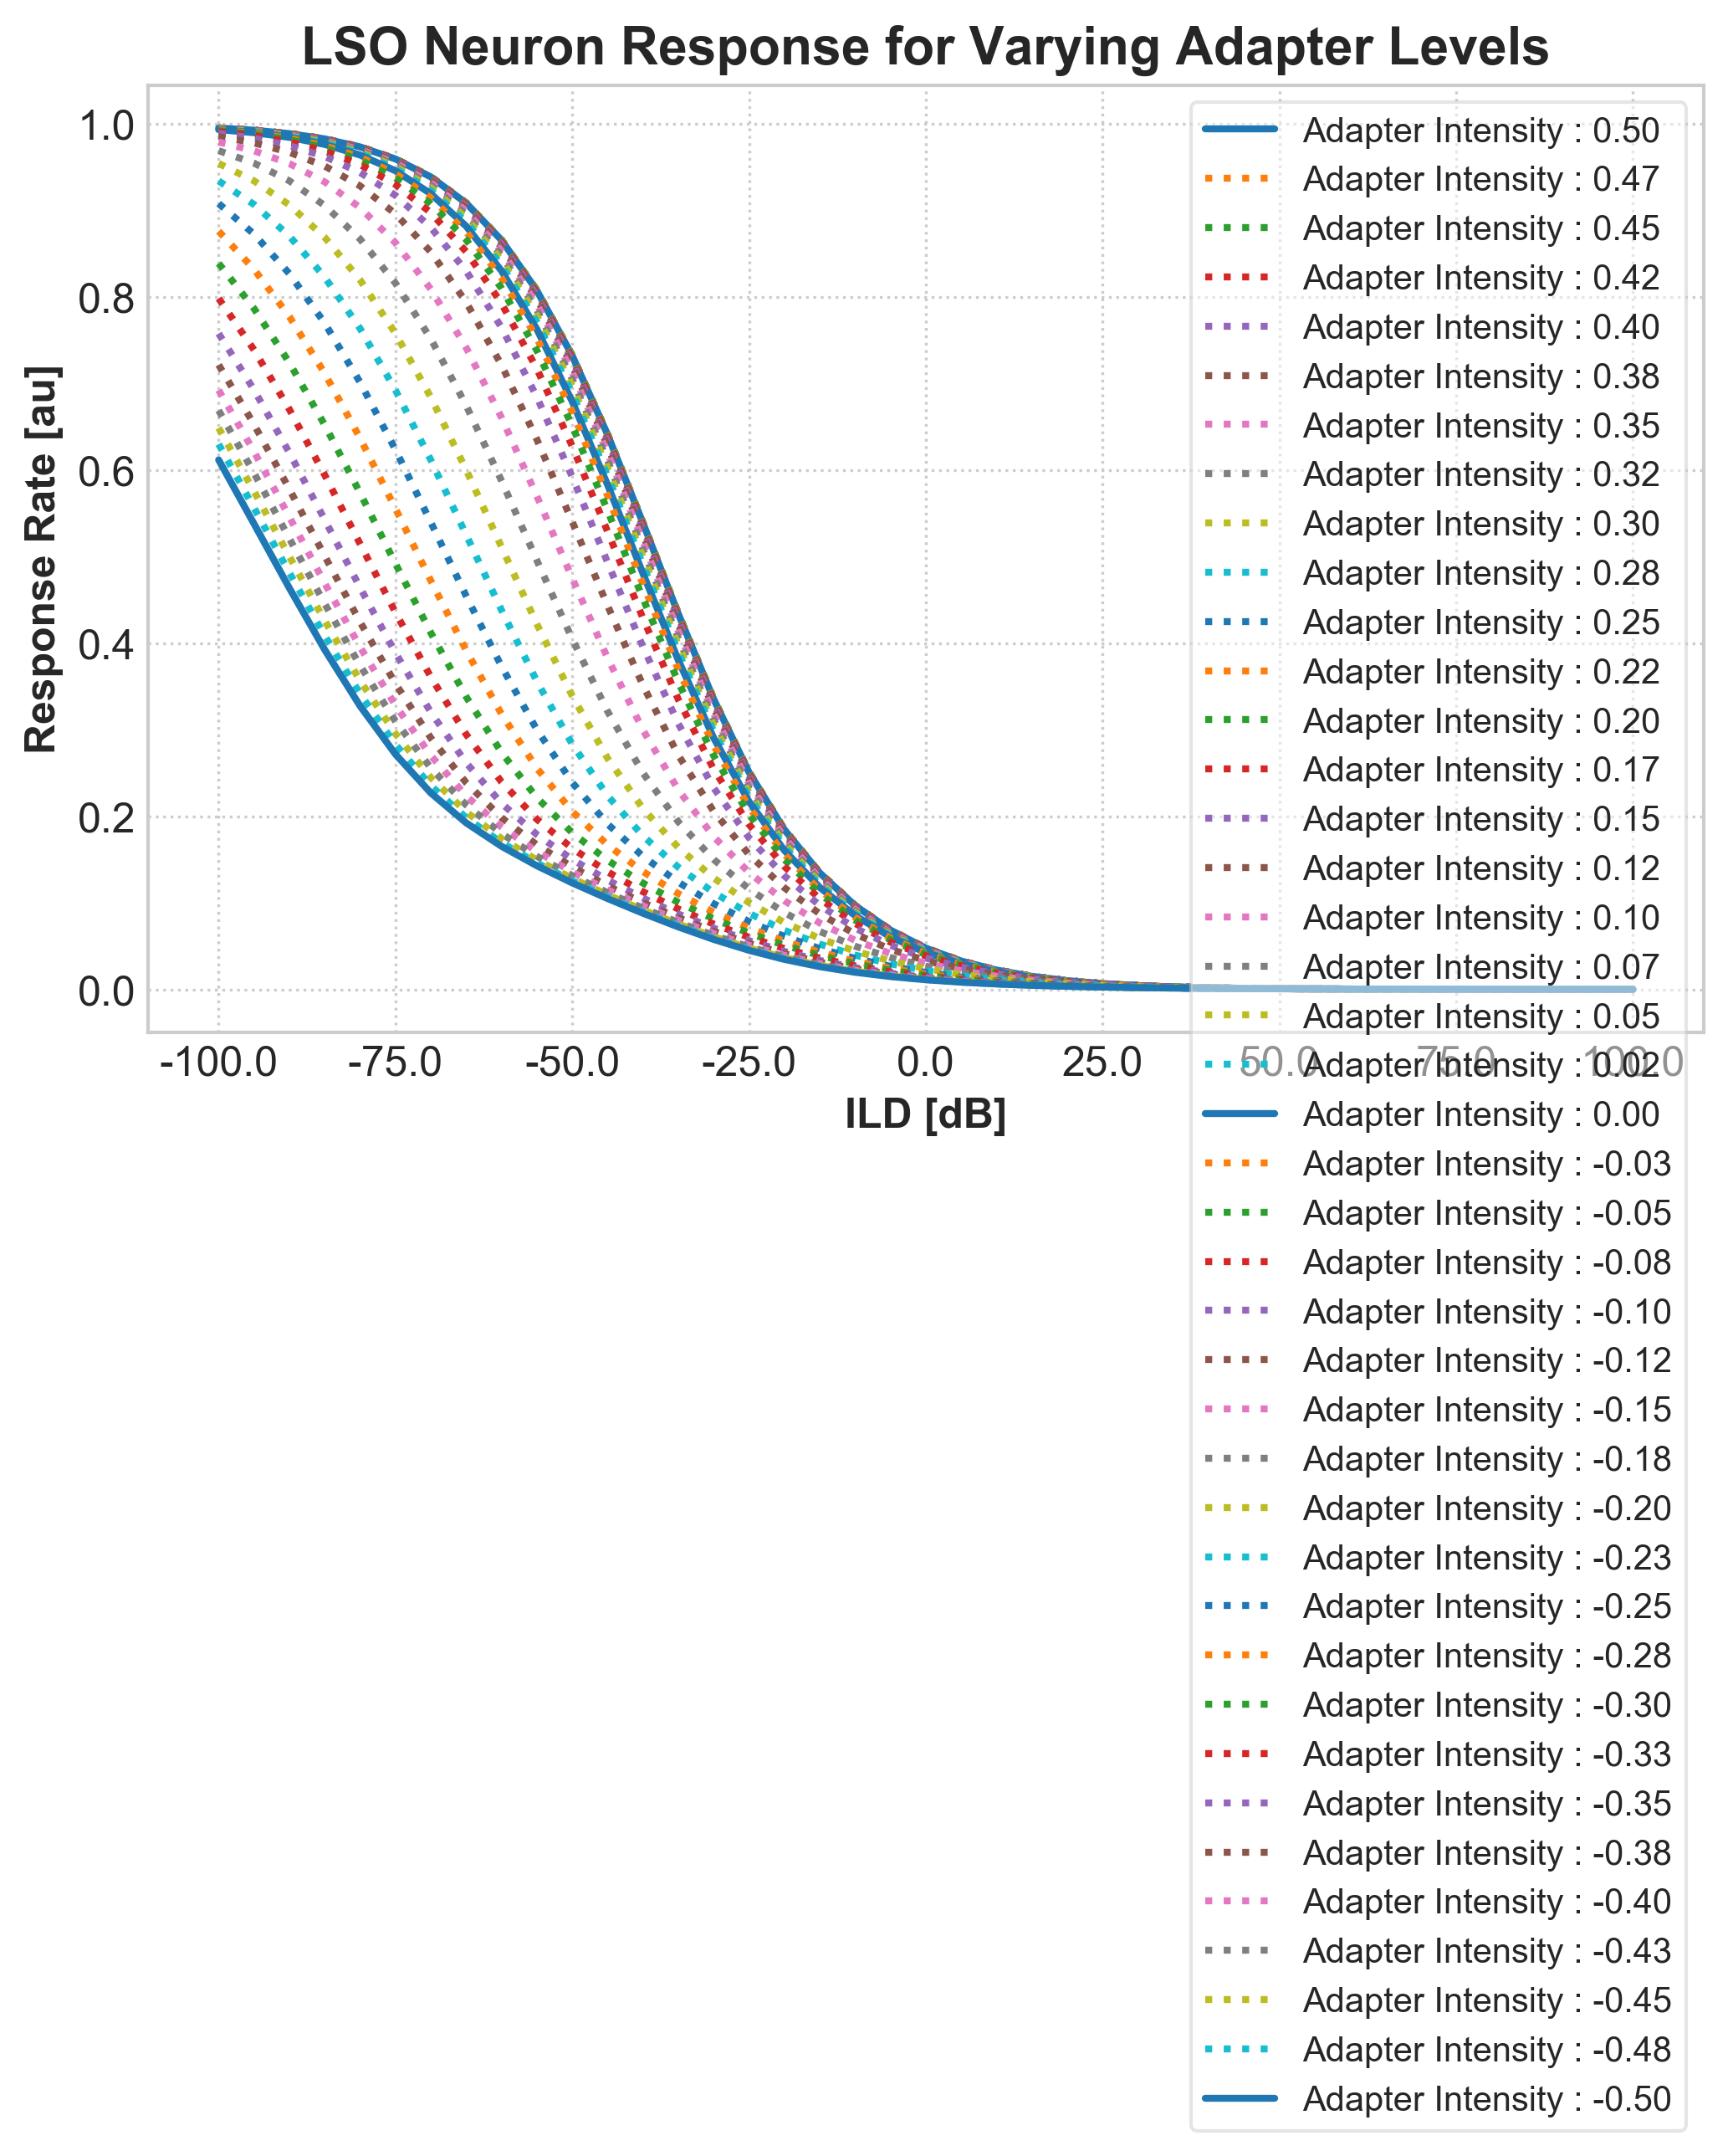

In [23]:
# Define the times when to probe
# probing_times = [2350]
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
for j in np.arange(0,len(adaptor_tone)):
    if j == 0 or j == len(adaptor_tone)-1 or adaptor_tone[j] == 0:
        line_style = '-'
    else:
        line_style = ':'
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
        diff = gbc_input_intensities-sbc_input_intensities
        ax2.plot(diff,tmp,linestyle=line_style,label='Adapter Intensity : {0:.2f}'.format(adaptor_tone[j]))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
# ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])

lgd = plt.legend()

plt.savefig(figure_name + 'response_shift.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




0.0


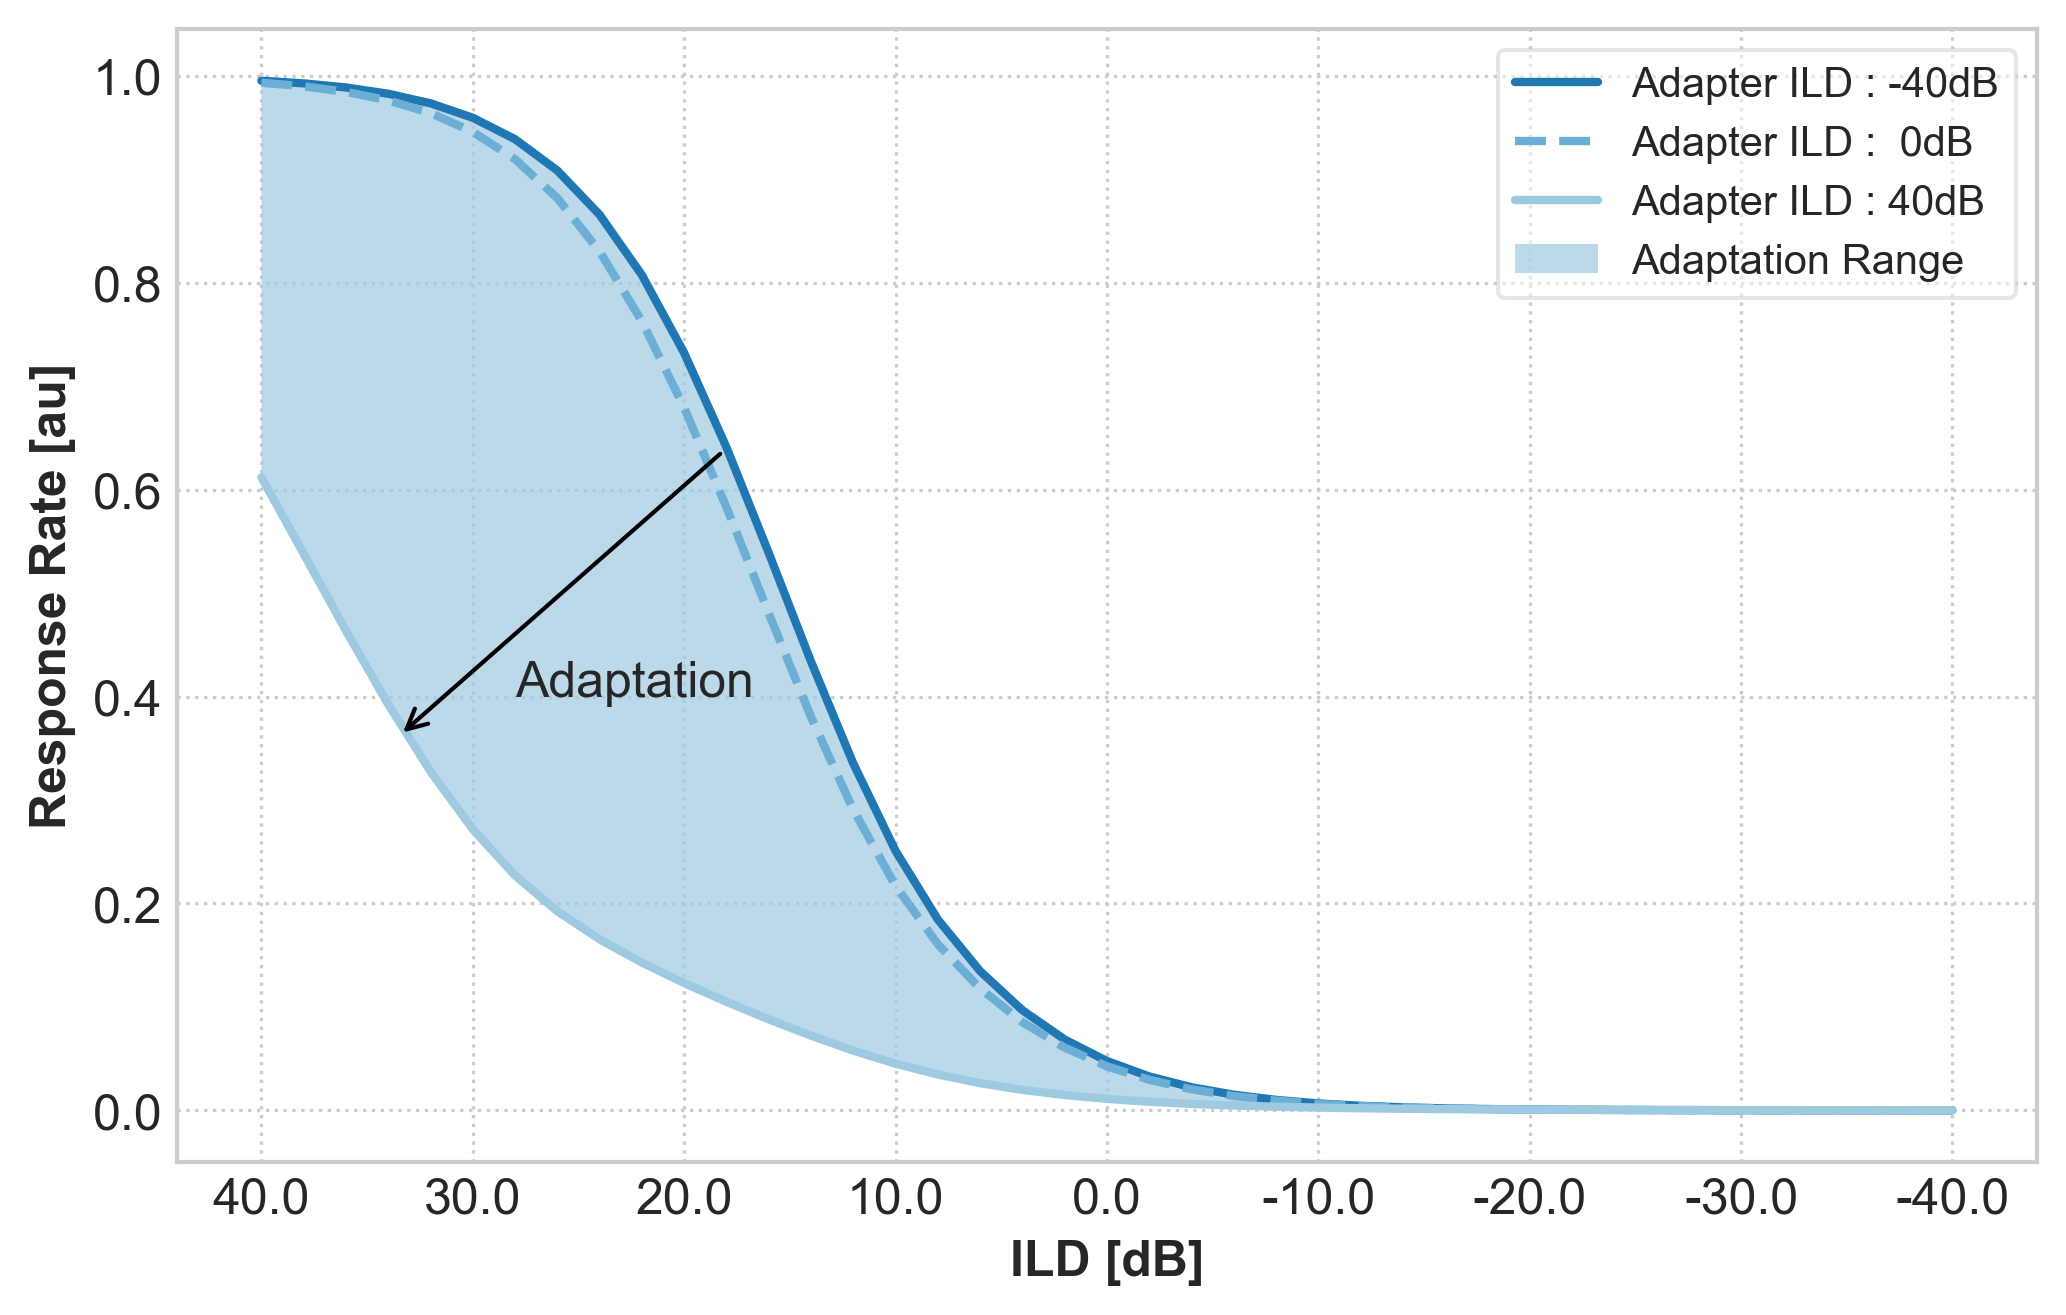

In [26]:
# Define the times when to probe
# probing_times = [2450]

fig = plt.figure()


diff = gbc_input_intensities-sbc_input_intensities

r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

## show LSO neuron response
ax2 = fig.add_subplot(111)
probing = probing_times[0]
print(adaptor_tone[20])

# tmp = g_r_out(r[20,:,probing])
# ax2.plot(-diff,tmp,linestyle='-',label='Adapter Intensity : {0:2.0f}dB'.format(adaptor_tone[20]*100))



tmp = g_r_out(r[0,:,probing])
ax2.plot(-diff,tmp,linestyle='-',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[0]*-80))

tmp1 = g_r_out(r[20,:,probing])
ax2.plot(-diff,tmp1,linestyle='--',color='#6baed6',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[20]*200))

tmp2 = g_r_out(r[-1,:,probing])
ax2.plot(-diff,tmp2,linestyle='-',color='#9ecae1',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[-1]*-80))

ax2.fill_between(-diff,tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Adaptation Range')

# ax2.annotate("", xy=(0.90, 0.5), xytext=(0.45, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=3))
# ax2.annotate("", xy=(1, 1), xytext=(1, 0.71),arrowprops=dict(arrowstyle="<->",linewidth=3))

ax2.annotate("", xy=(0.45, 0.64), xytext=(0.84, 0.36),arrowprops=dict(arrowstyle="<-",linewidth=1))
ax2.annotate("Adaptation", xy=(0.50, 0.45), xytext=(0.70, 0.40))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
# plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
lgd = plt.legend()

plt.savefig(figure_name + 'response_shift_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




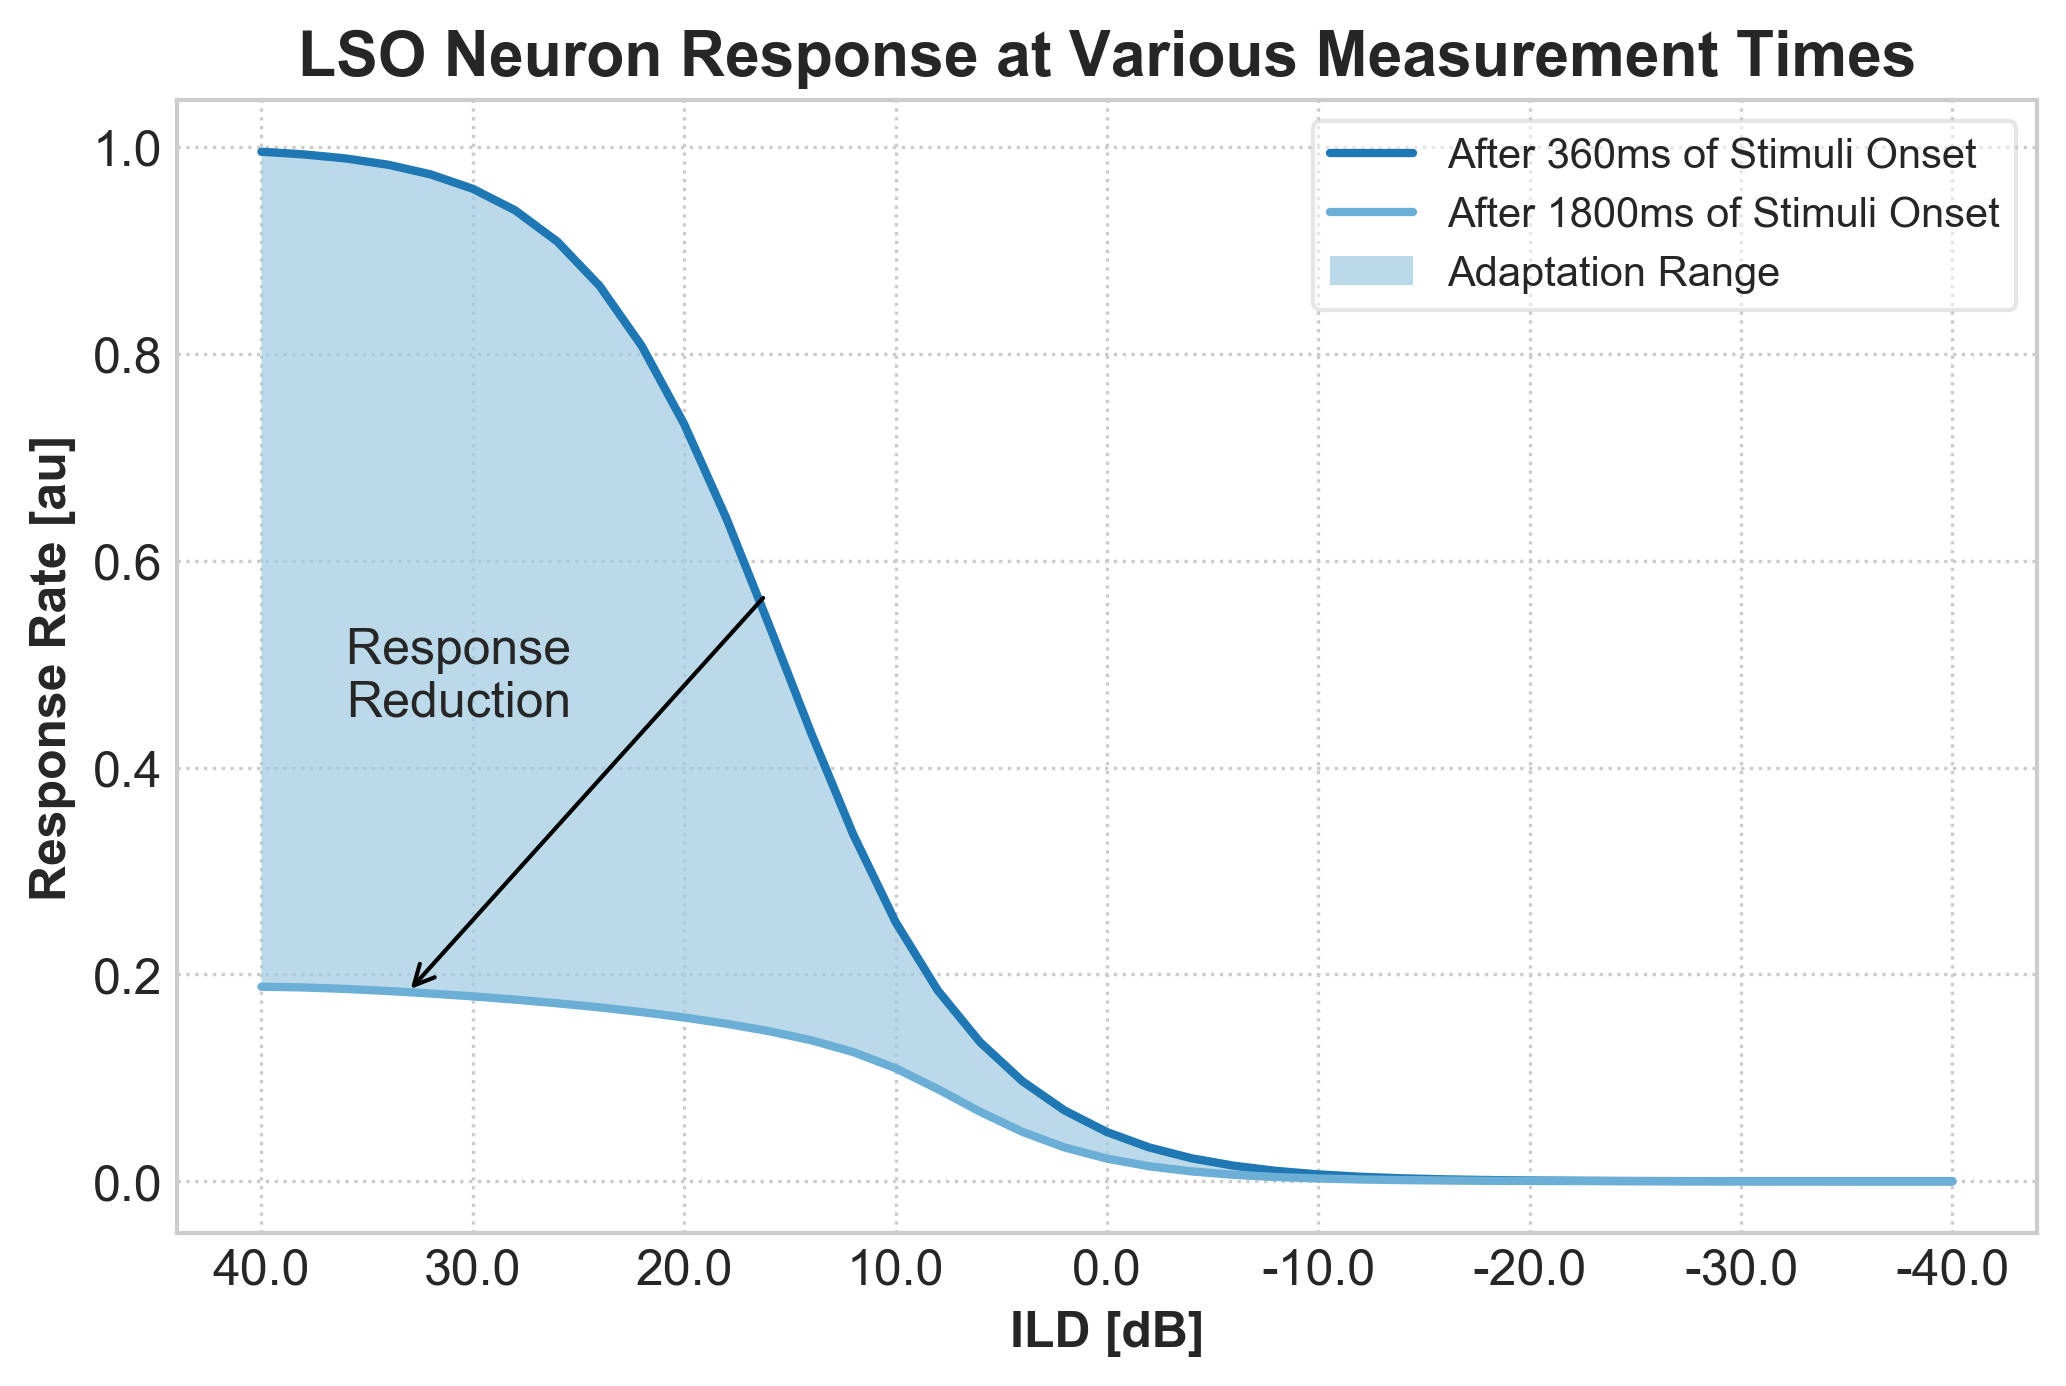

In [27]:
# Define the times when to probe
probing_times = range(2000,3100,100)
probing_times = [2360,3800]

fig = plt.figure()


diff = gbc_input_intensities-sbc_input_intensities

r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

## show LSO neuron response
ax2 = fig.add_subplot(111)

tmp = g_r_out(r[10,:,probing_times[0]])
ax2.plot(-diff,tmp,linestyle='-',label='After {0:.0f}ms of Stimuli Onset'.format(probing_times[0]-2000))

tmp2 = g_r_out(r[10,:,probing_times[1]])
# # normalize it
# tmp2 = tmp2 -  np.min(tmp2)
# tmp2 = tmp2 / np.max(tmp2)
ax2.plot(-diff,tmp2,linestyle='-',color='#6baed6',label='After {0:.0f}ms of Stimuli Onset'.format(probing_times[1]-2000))

ax2.fill_between(-diff,tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Adaptation Range')

# ax2.annotate("", xy=(0.90, 0.5), xytext=(0.45, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=3))
# ax2.annotate("", xy=(1, 1), xytext=(1, 0.71),arrowprops=dict(arrowstyle="<->",linewidth=3))

ax2.annotate("", xy=(0.40, 0.57), xytext=(0.83, 0.18),arrowprops=dict(arrowstyle="<-",linewidth=1))
ax2.annotate("Response \nReduction", xy=(0.90, 0.45), xytext=(0.90, 0.45))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response at Various Measurement Times')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)

lgd = plt.legend()
plt.savefig(figure_name + 'response_shift_measurement_times.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_measurement_times.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_measurement_times.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




(41,)


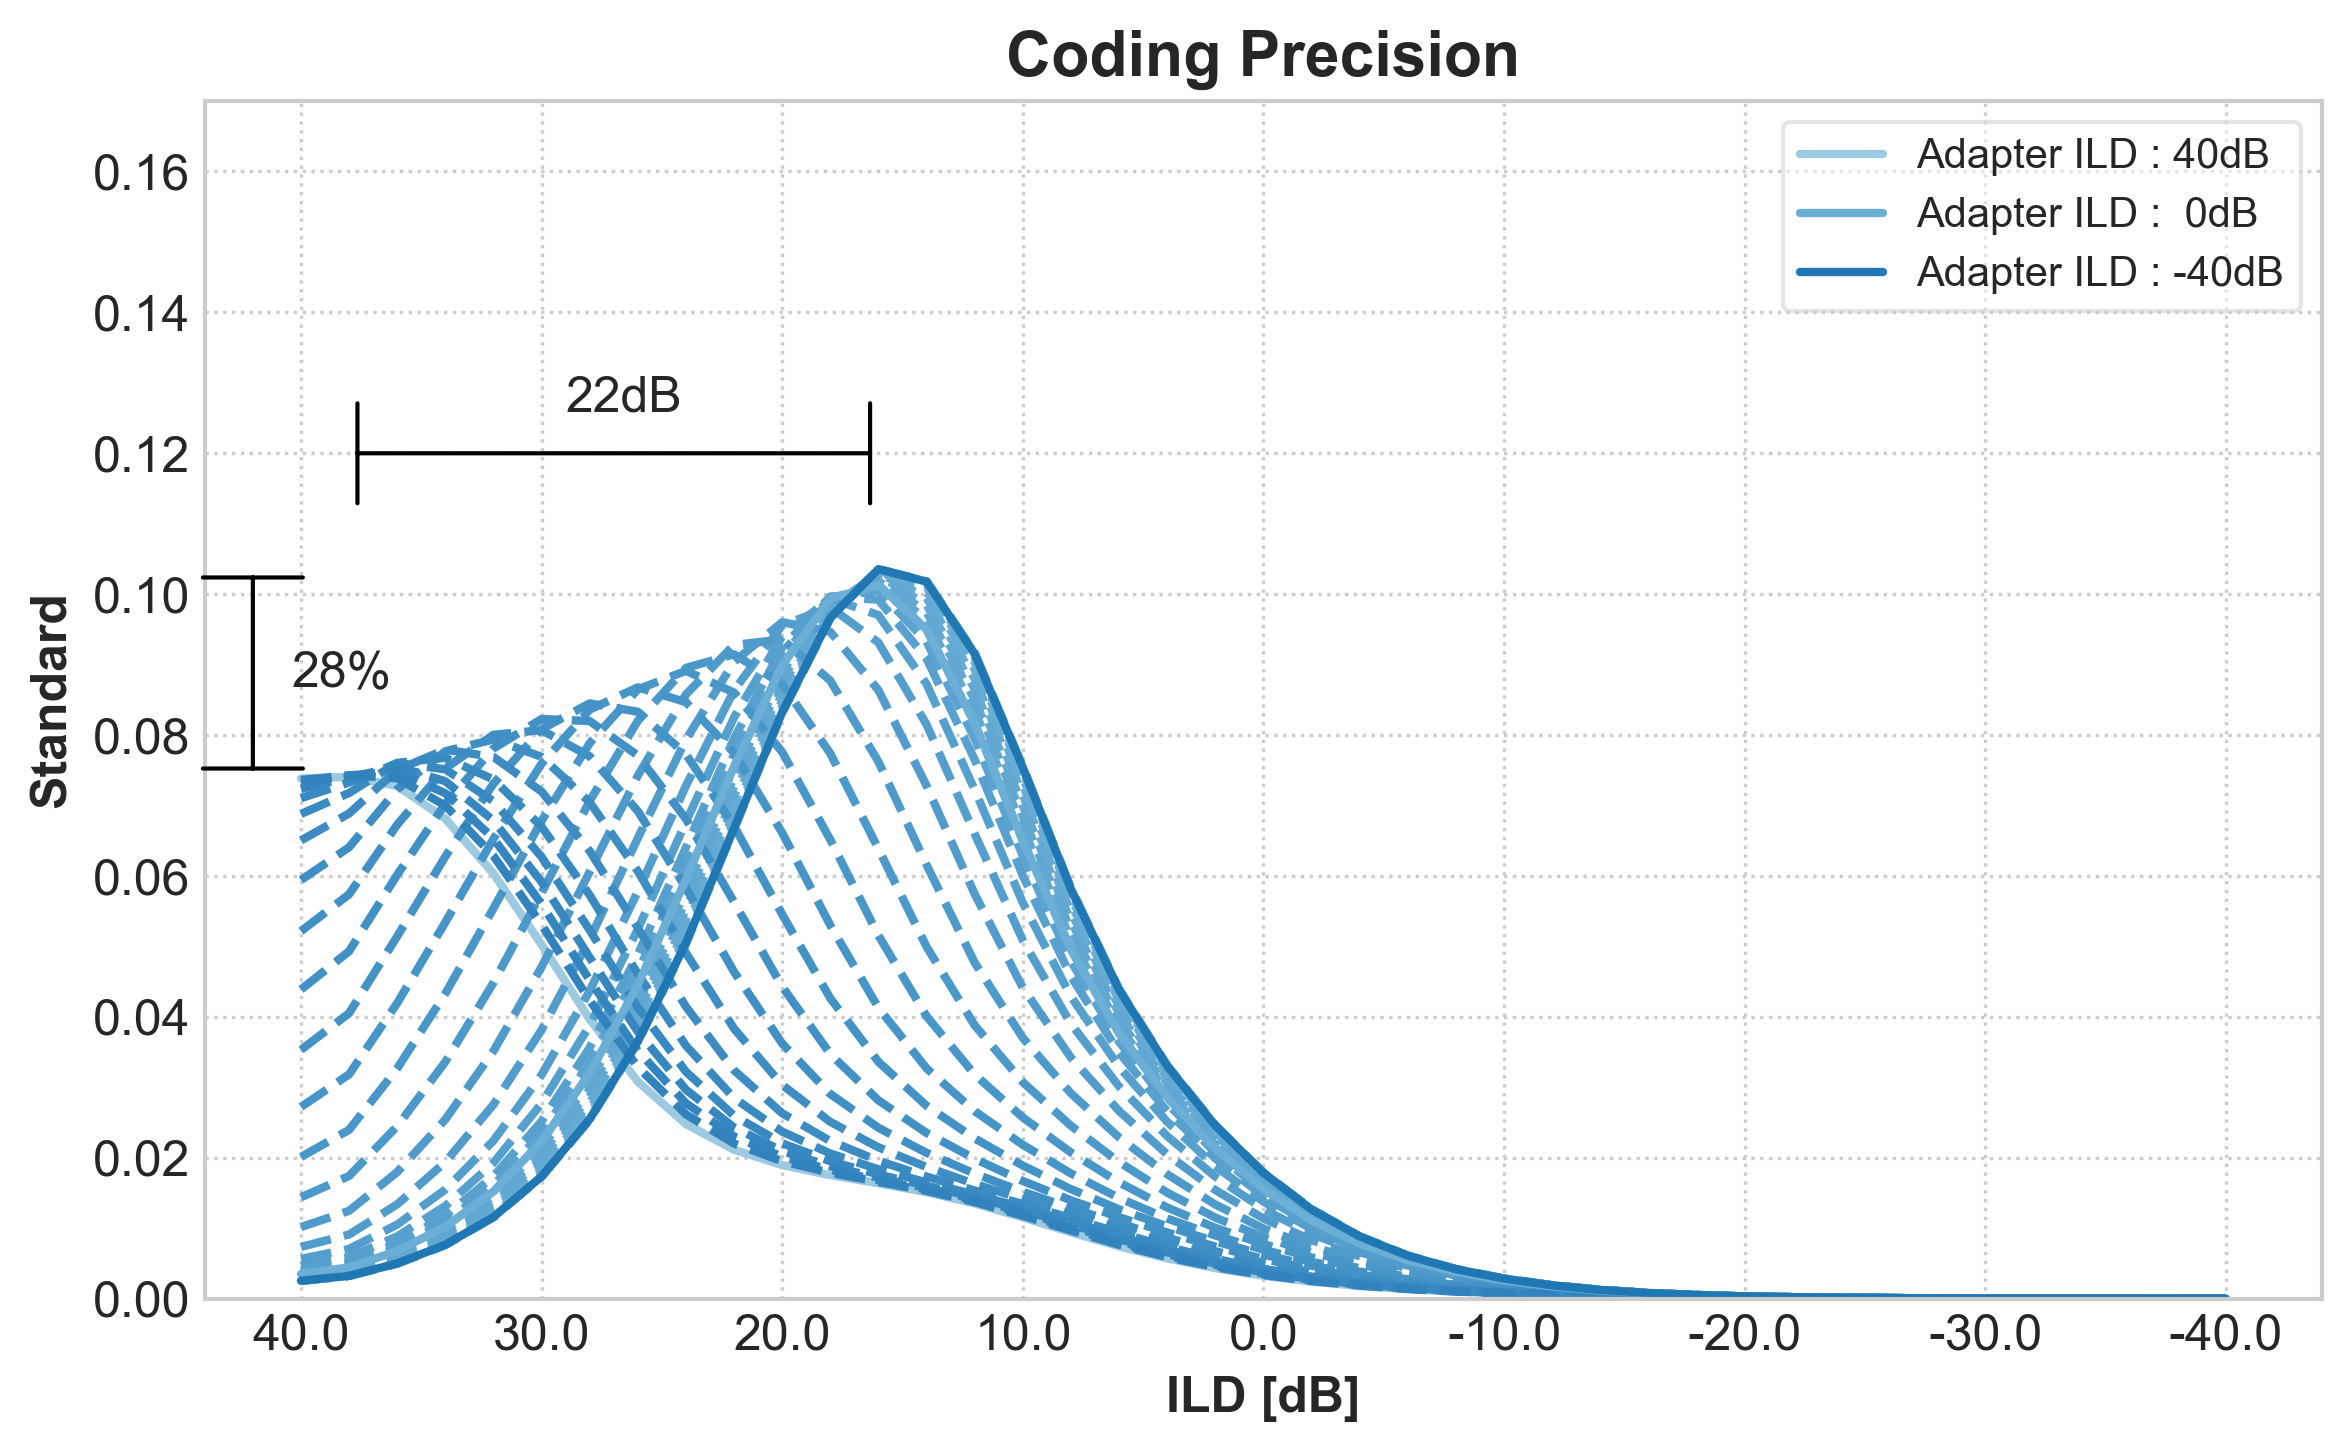

In [29]:
# fig = plt.figure()
# ax2 = fig.add_subplot(111)

probing_times = [2360]
## show LSO neuron response
# r = r_all[:,0::2,:,sbc_center_frequencyBand]
diff = gbc_input_intensities-sbc_input_intensities
# diff = diff[0::2]
print(diff.shape)
## show LSO neuron response
ilds = np.zeros((len(adaptor_tone),r.shape[1]))
## show LSO neuron response
for j in np.arange(0,len(adaptor_tone)):
    if j == 0 or j == len(adaptor_tone)-1:
        line_style = '-'
    else:
        line_style = ':'
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
#         tmp /= np.max(tmp)
        ilds[j,:] = tmp

# ilds = np.flip(ilds,0)    


# ax2.plot(diff,ilds.T)
# # plt.plot(ilds.T)
# ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# ax2.set_ylim([0,1.0])

# plt.title('Normalized Response')


from mpltools import color

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
colors = plt.cm.Blues(np.linspace(0.4,0.7,ilds.shape[1]))
ax2.set_prop_cycle('color', colors)
# ilds = ilds[:,::-1]

#normalize it
# ilds /= np.max(ilds.flatten())


#######
# DIFF
#######
# ax2.plot(-diff[:-1],-np.diff(ilds).T,linewidth = int(drawing_size/9),linestyle='--')

# tmp = g_r_out(r[0,:,probing])

# # tmp = tmp / np.max(tmp)

# ax2.plot(-diff[:-1],-np.diff(tmp),linestyle='-',color='C0',label='Adaptor Intensity : {0:2.0f}dB'.format(adaptor_tone[0]*100))

# tmp2 = g_r_out(r[-1,:,probing])

# # tmp2 = tmp2 / np.max(tmp2)
# ax2.plot(-diff[:-1],-np.diff(tmp2),linestyle='-',color='#6baed6',label='Adaptor Intensity : {0:2.0f}dB'.format(adaptor_tone[-1]*100))

###########
# GRADIENT
###########
tmp2 = g_r_out(r[-1,:,probing])

# tmp2 = tmp2 / np.max(tmp2)
ax2.plot(-diff,-np.gradient(tmp2),linestyle='-',color='#9ecae1',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[-1]*-80))

tmp =-np.array( np.gradient(ilds,axis=1))
ax2.plot(-diff,tmp.T[:,1:-1],linewidth = int(drawing_size/9),linestyle='--')

tmp = g_r_out(r[20,:,probing])
ax2.plot(-diff,-np.gradient(tmp),linestyle='-',color='#6baed6',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[20]*200))

tmp = g_r_out(r[0,:,probing])
ax2.plot(-diff,-np.gradient(tmp),linestyle='-',color='C0',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[0]*-80))




# calculate x value for first peak
x1 = diff[np.argmax(-np.gradient(tmp))]
x2 = diff[np.argmax(-np.gradient(tmp2))]
ax2.annotate("", xy=(-x2, 0.12), xytext=(-x1, 0.12),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=((x2-x1)/2 -x2+0.05, 0.126), xytext=((x2-x1)/2 -x2+0.05, 0.126))


y1 = np.max(-np.gradient(tmp))
y2 = np.max(-np.gradient(tmp2))
ax2.annotate("", xy=(1.05, y1), xytext=(1.05, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(1.01, y2+(y1-y2)/2), xytext=(1.01,  y2+(y1-y2)/2 -0.002))

l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
ax2.set_ylabel('Standard')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
ax2.set_ylim([0,0.17])
ax2.legend()
plt.title('Coding Precision')

plt.tight_layout()

plt.savefig(figure_name + 'coding_prescision.svg', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.tiff', bbox_inches='tight')

plt.show()



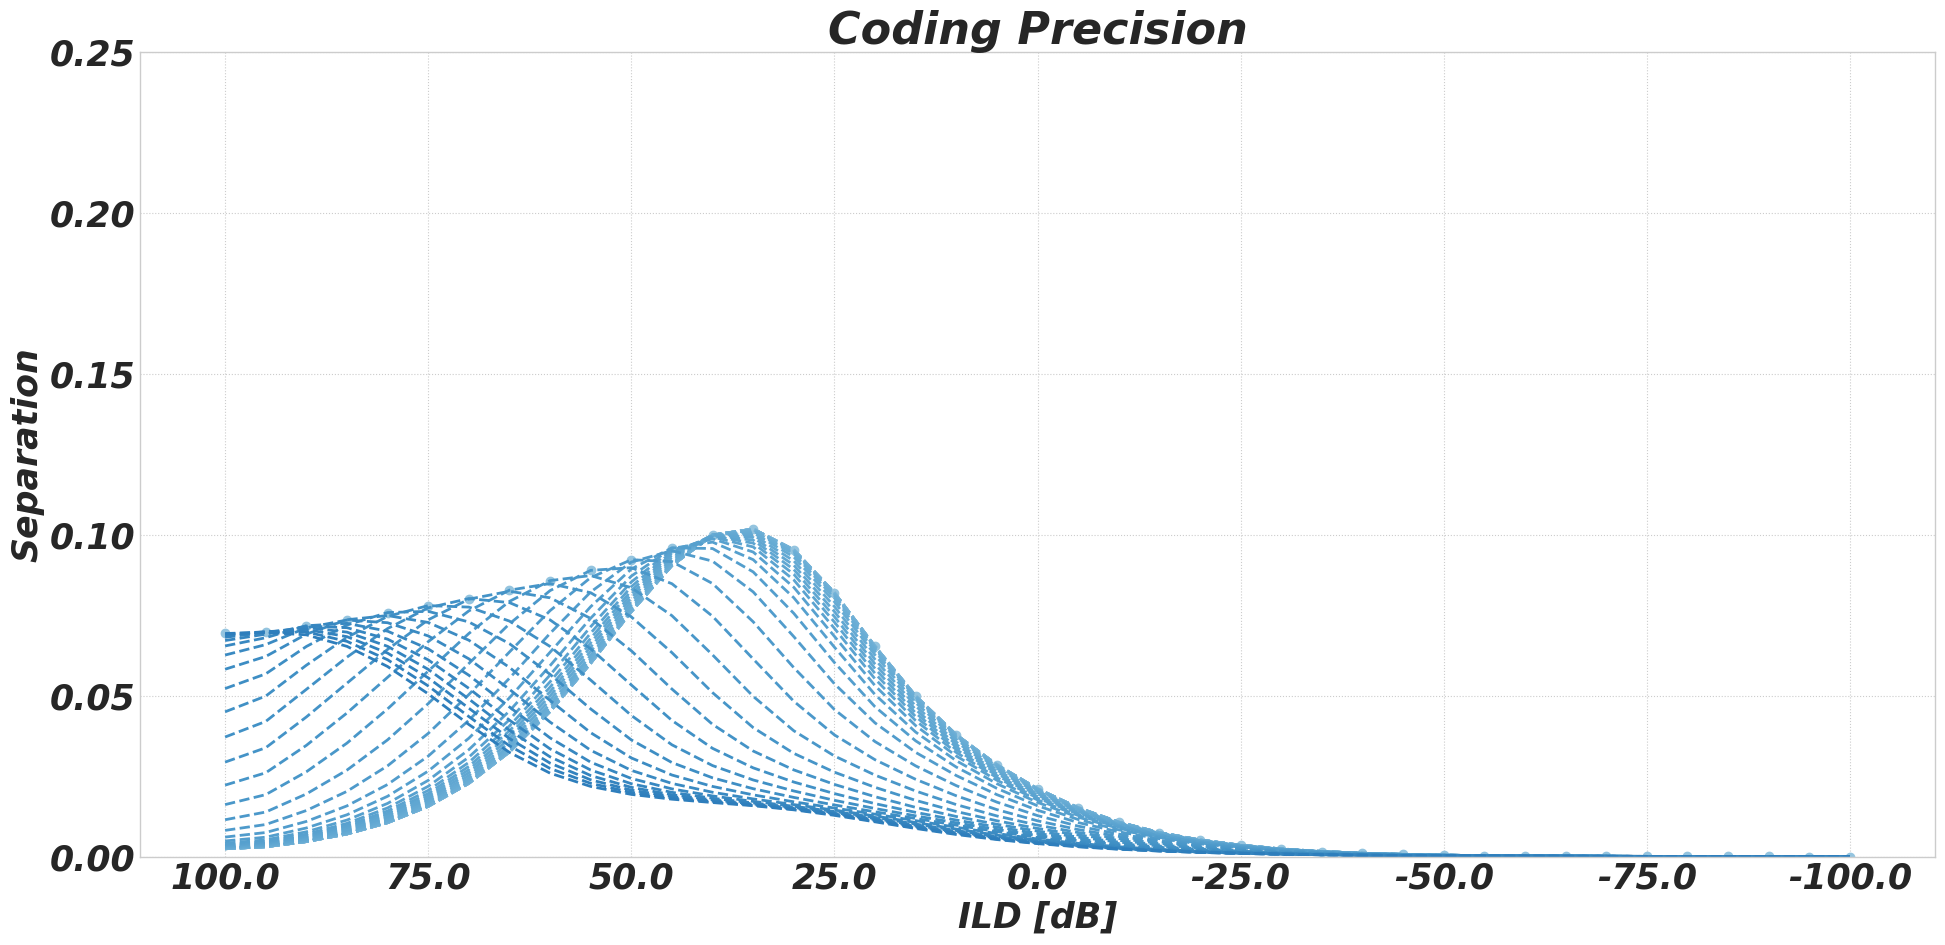

In [91]:
# fig = plt.figure()
# ax2 = fig.add_subplot(111)

# probing_times = [2360]
## show LSO neuron response

## show LSO neuron response
ilds = np.zeros((len(adaptor_tone),r.shape[1]))
## show LSO neuron response
for j in np.arange(0,len(adaptor_tone)):
    if j == 0 or j == len(adaptor_tone)-1:
        line_style = '-'
    else:
        line_style = ':'
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
#         tmp /= np.max(tmp)
        diff = gbc_input_intensities-sbc_input_intensities
        ilds[j,:] = tmp




from mpltools import color

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
colors = plt.cm.Blues(np.linspace(0.4,0.7,ilds.shape[1]))
ax2.set_prop_cycle('color', colors)
# ilds = ilds[:,::-1]

#normalize it
norm_value = np.max(ilds.flatten())
ilds /= norm_value



tmp =-np.array( np.gradient(ilds,axis=1))
# plot 0 ITD,

ax2.plot(-diff,tmp.T,linewidth = int(drawing_size/9),linestyle='--')

# ax2.plot(diff[np.argmax(tmp,axis=0)],np.max(tmp,axis=0))
ax2.scatter(-diff,np.max(tmp,axis=0))

# ax2.set_xticks(np.linspace(-1.0,1,9))
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
ax2.set_ylabel('Separation')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
ax2.set_ylim([0,0.25])
# ax2.set_xlim([1,-1])
# ax2.legend()
plt.title('Coding Precision')
# 
plt.tight_layout()

# saving:
f = open("precision_maxima_adaptation.csv", "w")
f.write("# x y\n")        # column names
np.savetxt(f, np.array([-diff, np.max(tmp,axis=0)]).T)

plt.show()


0.0


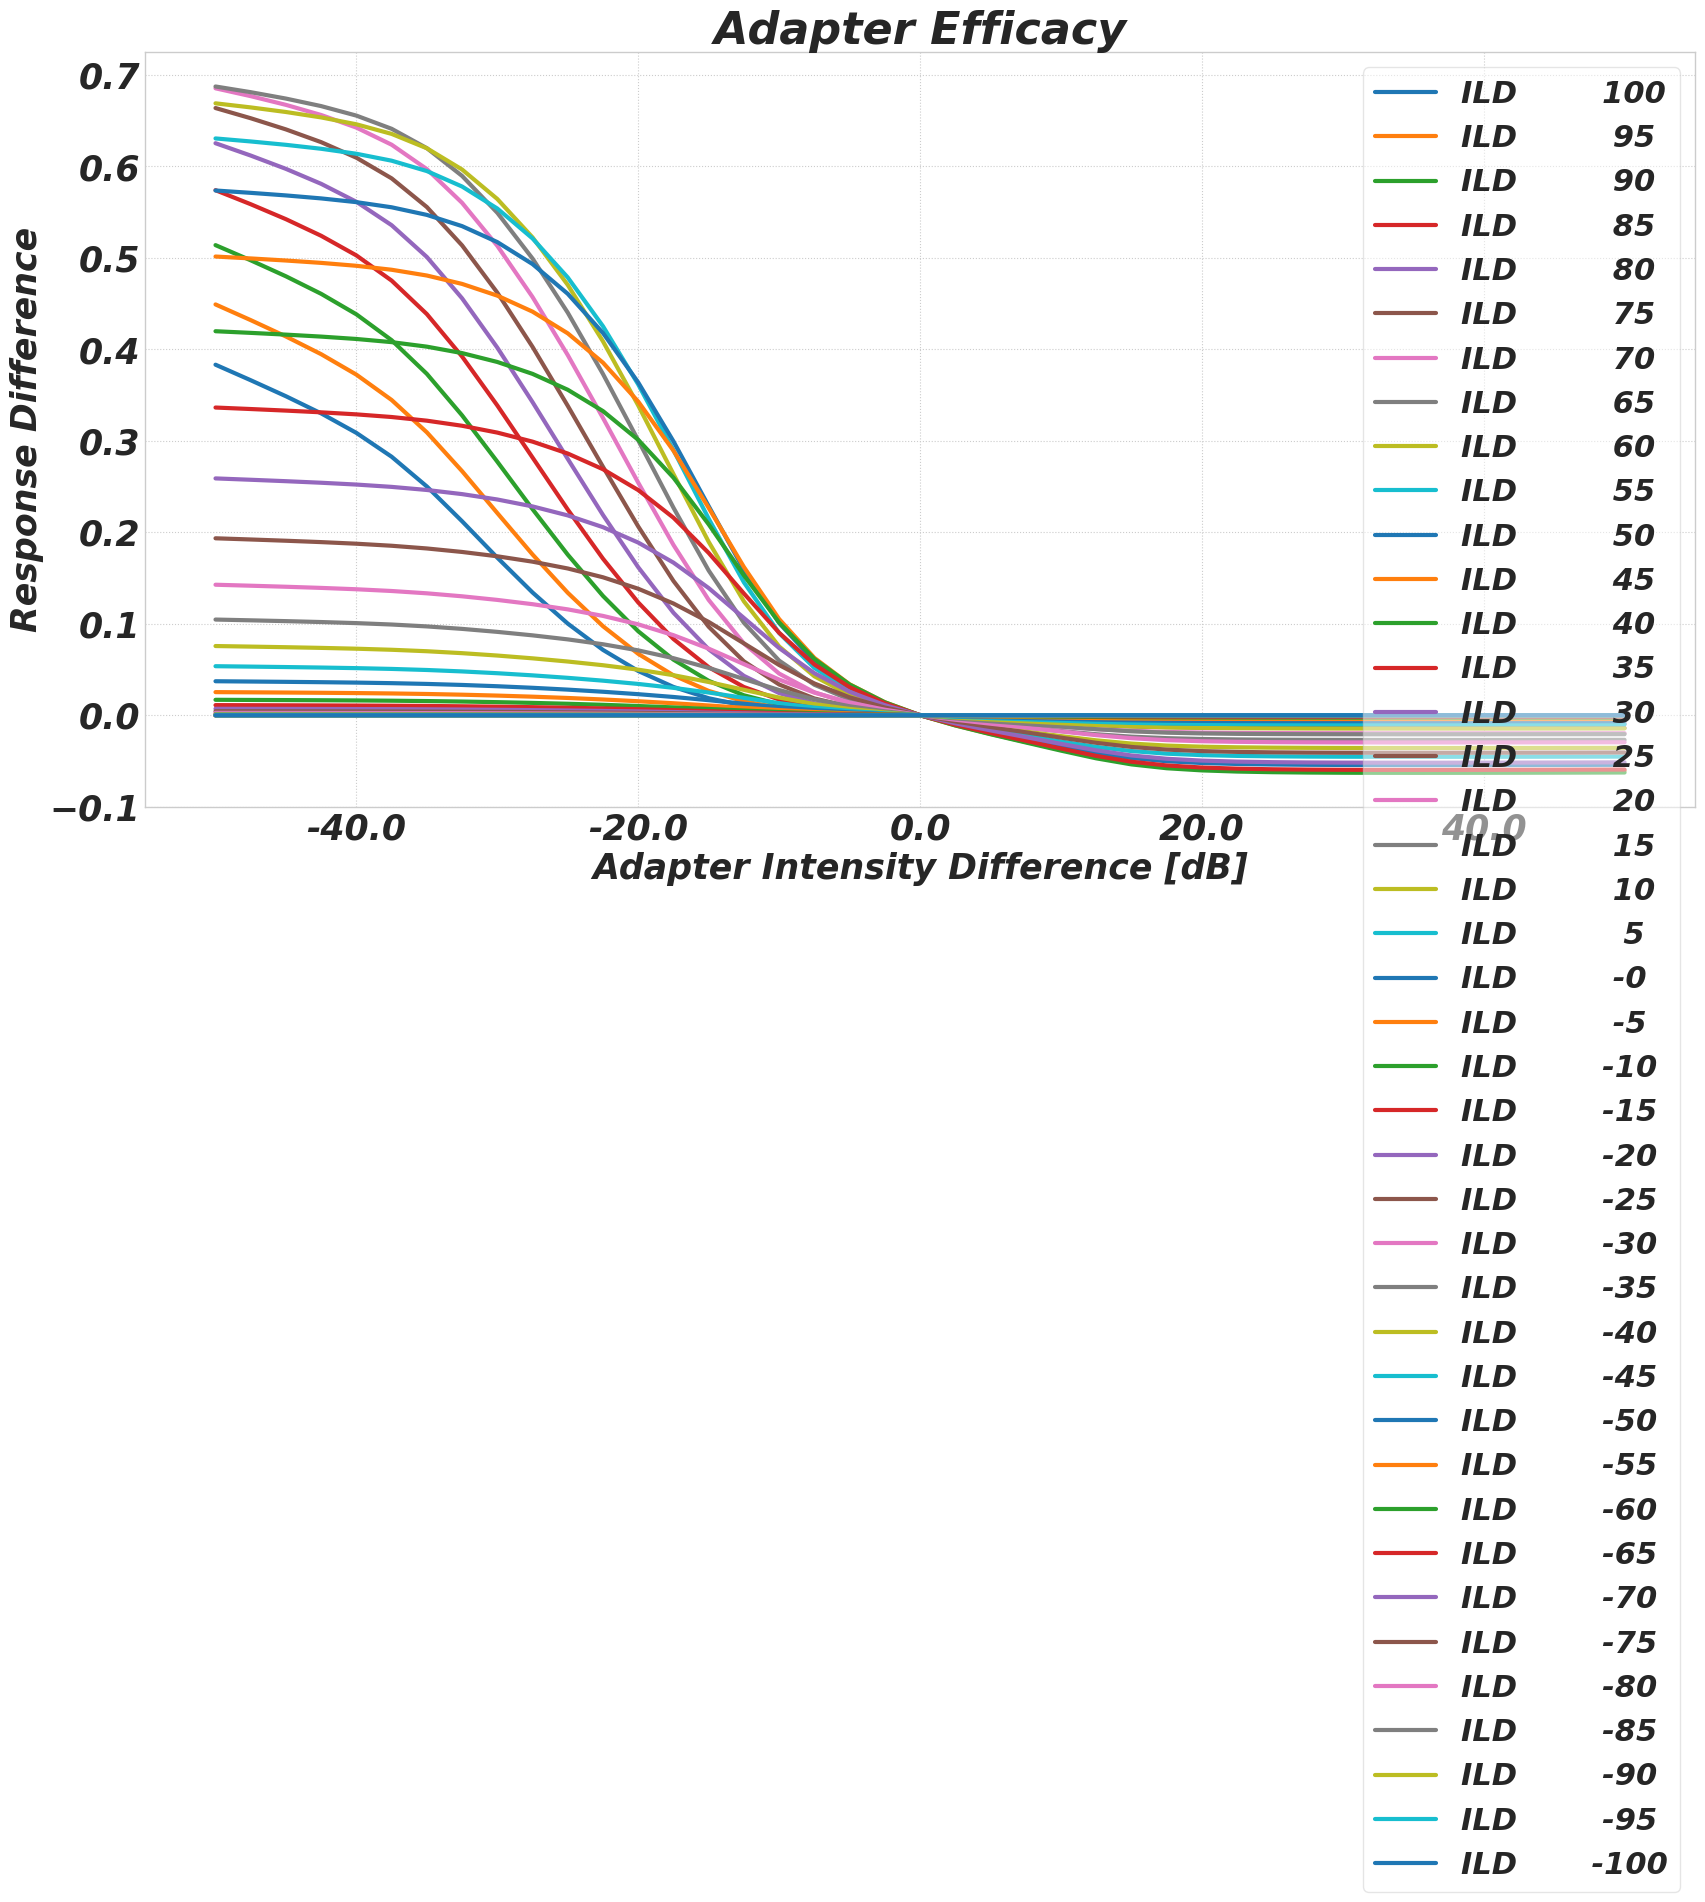

In [92]:
# fig = plt.figure()
# ax2 = fig.add_subplot(111)

## show LSO neuron response

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
print(adaptor_tone[20])
for i in range(ilds.shape[1]):
#     ax2.plot(adaptor_tone,100/ilds[9,i] * ilds[:,i],linewidth= 3,label='ILD {0:10.0f}'.format(100*-diff[i]))
    ax2.plot(adaptor_tone,ilds[20,i] - ilds[:,i],linewidth= 3,label='ILD {0:10.0f}'.format(100*-diff[i]))
#     ax2.plot(adaptor_tone, ilds[:,i],linewidth= 3,label='ILD {0:10.0f}'.format(100*-diff[i]))

# ax2.pcolormesh(ilds[0,:]-ilds[:,:])

# ax2.plot(adaptor_tone,1-ilds[:,0],label='ILD {0:10.0f}'.format(100*diff[0]))

ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# ax2.set_yticklabels([ round(k * 100) for k in ax2.get_yticks()])
ax2.set_ylabel('Response Difference')
ax2.set_xlabel('Adapter Intensity Difference [dB]')
# ax2.invert_yaxis()
# ax2.set_ylim([0,0.23])
ax2.legend()
plt.title('Adapter Efficacy')

# plt.tight_layout()

# plt.savefig(figure_name + 'n.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'n.pdf', bbox_inches='tight')

plt.show()



###  The plot shows that the highest depression rate (response compared to baseline, which is the response for 0dB adaptor tone) is (as expected) achieved for a adaptor intensity of -50dB and for a ILD of 47dB. However the most effective adaptor changes with presented ILD. For example an adaptor tone of 30dB is most effective for ILDs of 37dB, and for an adaptor tone of 20dB the strongest depressed ILD is 26dB. Knowing that we can now create a plot that shows the relation of adaptor tone to most effectecd ILD. We expected that it is almost linear and that it is in the same range.



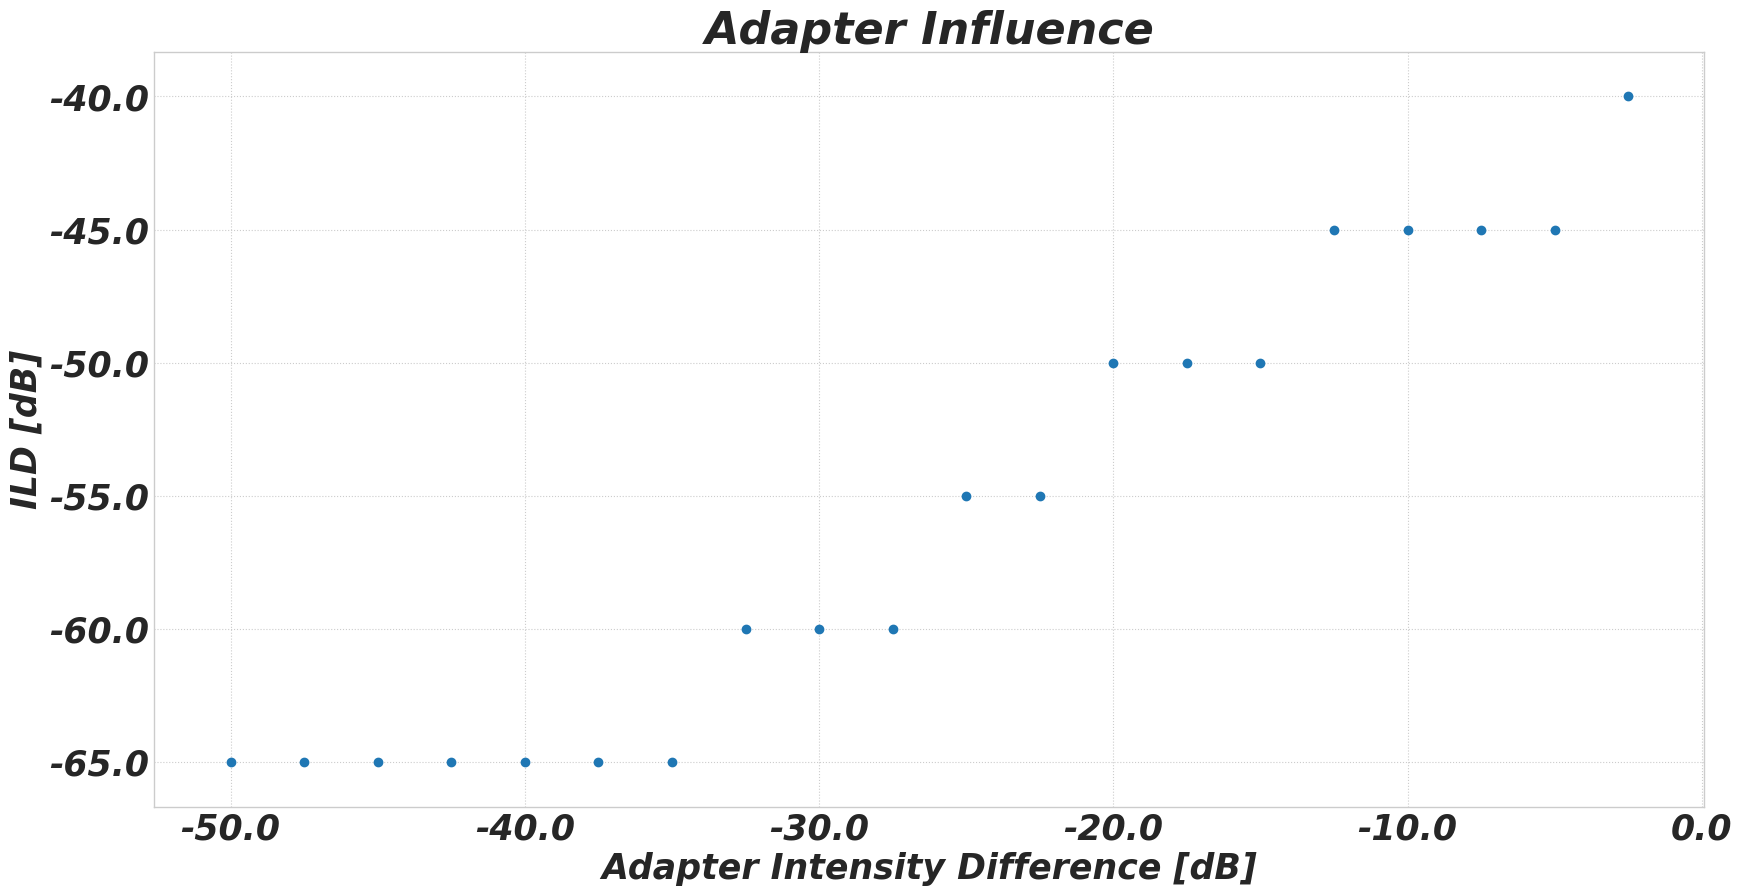

In [93]:
fig = plt.figure()
## show LSO neuron response
ax2 = fig.add_subplot(111)
ild_depression = np.zeros(ilds.shape)
for i in range(0,ilds.shape[1]):
     ild_depression[i,:] = ilds[20,i]-ilds[:,i]
        
# print(np.argmax(ild_depression,axis = 0))
# print(diff[np.argmax(ild_depression,axis = 0)]*100)


# ax2.plot(adaptor_tone,ild_depression.T)

ax2.scatter(adaptor_tone[21:],diff[np.argmax(ild_depression[:,21:],axis = 0)],marker='o')
ax2.set_ylabel('ILD [dB]')
ax2.set_xlabel('Adapter Intensity Difference [dB]') 
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
ax2.set_yticklabels([ round(k * 100) for k in ax2.get_yticks()])
ax2.set_title('Adapter Influence')

# plt.savefig(figure_name + 'adaptor_influence.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'adaptor_influence.pdf', bbox_inches='tight')


plt.show()

(41,)


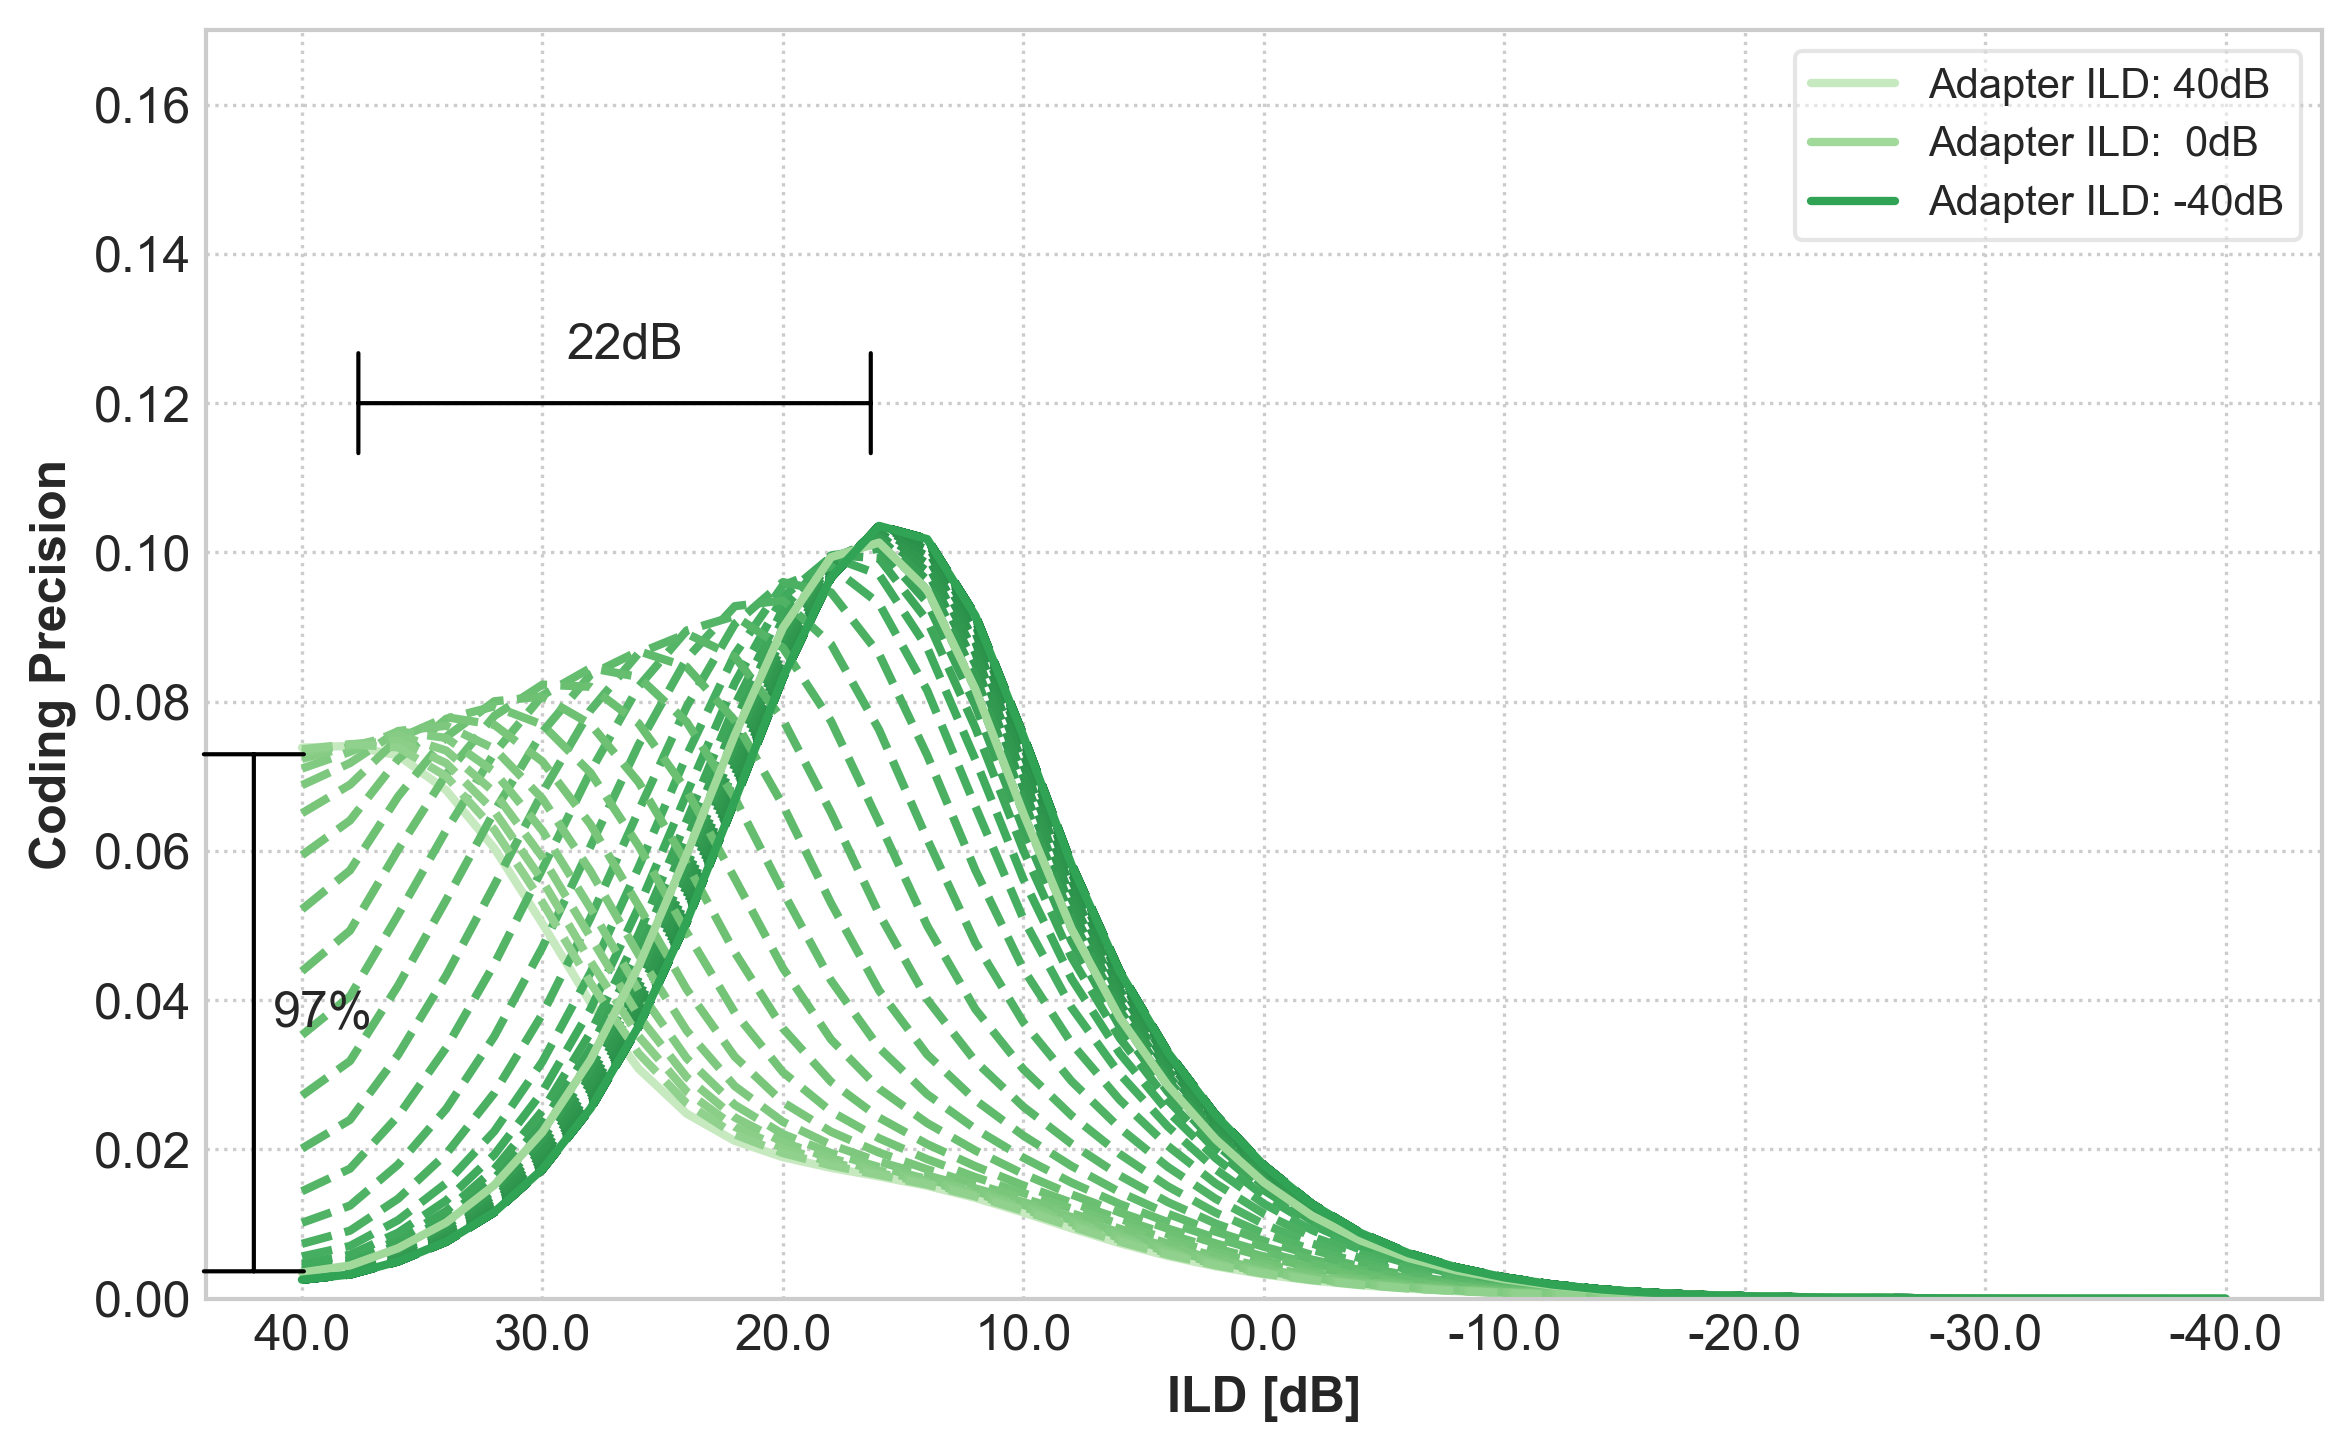

In [31]:
# fig = plt.figure()
# ax2 = fig.add_subplot(111)

probing_times = [2360]
## show LSO neuron response
# r = r_all[:,0::2,:,sbc_center_frequencyBand]
diff = gbc_input_intensities-sbc_input_intensities
# diff = diff[0::2]
print(diff.shape)
## show LSO neuron response
ilds = np.zeros((len(adaptor_tone),r.shape[1]))
## show LSO neuron response
for j in np.arange(0,len(adaptor_tone)):
    if j == 0 or j == len(adaptor_tone)-1:
        line_style = '-'
    else:
        line_style = ':'
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
#         tmp /= np.max(tmp)
        ilds[j,:] = tmp

# ilds = np.flip(ilds,0)    


# ax2.plot(diff,ilds.T)
# # plt.plot(ilds.T)
# ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# ax2.set_ylim([0,1.0])

# plt.title('Normalized Response')


from mpltools import color

fig = plt.figure()
# fig = plt.figure(figsize=(8,3),dpi=72)


# mpl.rcParams.update({'font.size': 12,'figure.titlesize':12,'axes.labelsize':12,'axes.titlesize':12,'legend.fontsize':12})
# mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)

# mpl.rcParams['axes.labelsize'] = drawing_size

# mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)

# mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)


## show LSO neuron response
ax2 = fig.add_subplot(111)
colors = plt.cm.Greens(np.linspace(0.9,0.4,ilds.shape[1]))
ax2.set_prop_cycle('color', colors)
# ilds = ilds[:,::-1]
#normalize it
# ilds /= np.max(ilds.flatten())


#######
# DIFF
#######
# ax2.plot(-diff[:-1],-np.diff(ilds).T,linewidth = int(drawing_size/9),linestyle='--')

# tmp = g_r_out(r[0,:,probing])

# # tmp = tmp / np.max(tmp)

# ax2.plot(-diff[:-1],-np.diff(tmp),linestyle='-',color='C0',label='Adaptor Intensity : {0:2.0f}dB'.format(adaptor_tone[0]*100))

# tmp2 = g_r_out(r[-1,:,probing])

# # tmp2 = tmp2 / np.max(tmp2)
# ax2.plot(-diff[:-1],-np.diff(tmp2),linestyle='-',color='#6baed6',label='Adaptor Intensity : {0:2.0f}dB'.format(adaptor_tone[-1]*100))

###########
# GRADIENT
###########
tmp2 = g_r_out(r[-1,:,probing])

# tmp2 = tmp2 / np.max(tmp2)
ax2.plot(-diff,-np.gradient(tmp2),linestyle='-',color='#c7e9c0',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[-1]*-80))

tmp =-np.array( np.gradient(ilds,axis=1))
ax2.plot(-diff,tmp.T[:,1:-1],linewidth = int(drawing_size/9),linestyle='--')

tmp = g_r_out(r[20,:,probing])
ax2.plot(-diff,-np.gradient(tmp),linestyle='-',color='#a1d99b',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[20]*200))

tmp = g_r_out(r[0,:,probing])
ax2.plot(-diff,-np.gradient(tmp),linestyle='-',color='#31a354',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[0]*-80))




# calculate x value for first peak
x1 = diff[np.argmax(-np.gradient(tmp))]
x2 = diff[np.argmax(-np.gradient(tmp2))]
ax2.annotate("", xy=(-x2, 0.12), xytext=(-x1, 0.12),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=((x2-x1)/2 -x2+0.05, 0.126), xytext=((x2-x1)/2 -x2+0.05, 0.126))


y1 = np.max(-np.gradient(tmp2))
y2 = np.max(-np.gradient(tmp2))
y1_ind = np.argmax(-np.gradient(tmp))
y2 = np.gradient(-np.gradient(tmp))[y1_ind]

ax2.annotate("", xy=(1.05, y1), xytext=(1.05, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(1.03, y2+(y1-y2)/2), xytext=(1.03,  y2+(y1-y2)/2 -0.002))

l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
ax2.set_ylabel('Coding Precision')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
ax2.set_ylim([0,0.17])
# ax2.legend(loc=(1.04,0))
ax2.legend()
# plt.title('Coding Precision')

plt.tight_layout()

plt.savefig(figure_name + 'coding_prescision_green.svg', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision_green.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision_green.pdf', bbox_inches='tight')

plt.show()

